In [1]:
import numpy as np
import glob
import re
import matplotlib.pyplot as plt
from scipy.io import loadmat
import math
import h5py
import os.path


import torch.nn.functional as F
from timeit import default_timer
from catheter import *
from utilities3 import *
from Adam import Adam

torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True


# Length based data

In [2]:
PATH = "/home/wumming/Documents/GNN-PDE/Geo-FNO-catheter/data/"
INPUT_X = PATH+"x_1d_structured_mesh.npy"
INPUT_Y = PATH+"y_1d_structured_mesh.npy"
INPUT_para = PATH+"data_info.npy"
OUTPUT = PATH+"density_1d_data.npy"
n_data = 3000
inputX_raw = np.load(INPUT_X)[:,0:n_data]
inputY_raw = np.load(INPUT_Y)[:,0:n_data]
inputPara_raw = np.load(INPUT_para)[:,0:n_data]
output_raw = np.load(OUTPUT)[:,0:n_data]



PATH ="/home/wumming/Documents/GNN-PDE/Geo-FNO-catheter/data/test/"
INPUT_X = PATH+"x_1d_structured_mesh.npy"
INPUT_Y = PATH+"y_1d_structured_mesh.npy"
INPUT_para = PATH+"data_info.npy"
OUTPUT = PATH+"density_1d_data.npy"
n_data = 300
inputX_test_raw = np.load(INPUT_X)[:,0:n_data]
inputY_test_raw = np.load(INPUT_Y)[:,0:n_data]
inputPara_test_raw = np.load(INPUT_para)[:,0:n_data]
output_test_raw = np.load(OUTPUT)[:,0:n_data]

N_s, L_x = 2001, 500


Text(0, 0.5, 'L_p')

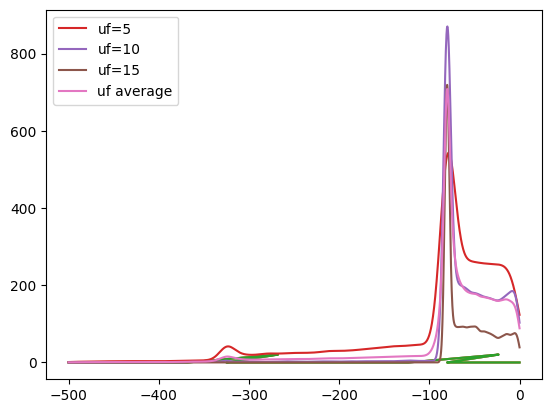

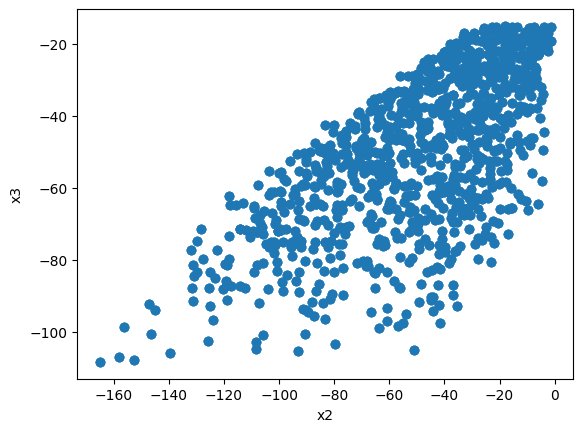

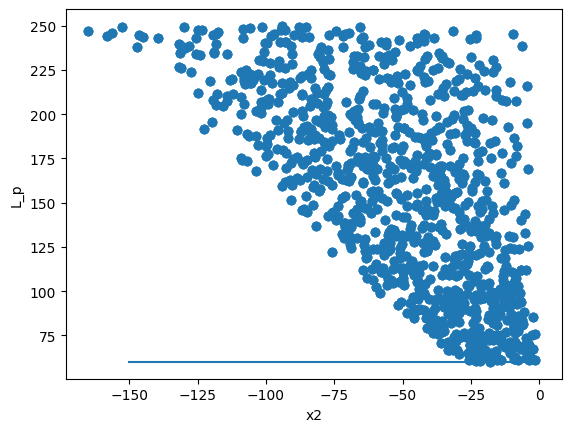

In [3]:
# Combine data
plt.figure()
test_id = 0
plt.plot(inputX_raw[:,3*test_id], inputY_raw[:,3*test_id])
plt.plot(inputX_raw[:,3*test_id+1], inputY_raw[:,3*test_id+1])
plt.plot(inputX_raw[:,3*test_id+2], inputY_raw[:,3*test_id+2])
sample, uf, L_p, x1, x2, x3, h = inputPara_raw[:,3*test_id]

xx = np.linspace(-L_x, 0, N_s)
plt.plot(xx, output_raw[:,3*test_id], label="uf=5")
plt.plot(xx, output_raw[:,3*test_id+1], label="uf=10")
plt.plot(xx, output_raw[:,3*test_id+2], label="uf=15")
plt.plot(xx, (output_raw[:,3*test_id]+output_raw[:,3*test_id+1]+output_raw[:,3*test_id+2])/3, label="uf average")
plt.legend()

plt.figure()
plt.scatter(inputPara_raw[4,:], inputPara_raw[5,:])
plt.xlabel("x2")
plt.ylabel("x3")

plt.figure()
plt.scatter(inputPara_raw[4,:], inputPara_raw[2,:])
plt.plot(np.linspace(-150,0,100), np.linspace(60,60,100))
plt.xlabel("x2")
plt.ylabel("L_p")


In [4]:
torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True


# zero tests 

ntrain = 1000
ntest = 100

batch_size = 20
learning_rate = 0.001
epochs = 1001
step_size = 100
gamma = 0.5

n_periods = 10
modes = 64
width = 64
s = N_s

################################################################
# load training data
################################################################
inputX = inputX_raw[:, 0::3]
inputY = inputY_raw[:, 0::3]
inputPara = inputPara_raw[:, 0::3]
output = (output_raw[:, 0::3] + output_raw[:, 1::3] + output_raw[:, 2::3])/ 3.0
inputX = torch.tensor(inputX, dtype=torch.float).permute(1,0)
inputY = torch.tensor(inputY, dtype=torch.float).permute(1,0)
input = torch.stack([inputX, inputY], dim=-1)
output = torch.tensor(output, dtype=torch.float).permute(1,0)
index = torch.randperm(ntrain)
train_index = index[:ntrain]
x_train = input[train_index]
y_train = output[train_index]
x_train = x_train.reshape(ntrain, s, 2)
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size,
                                           shuffle=True)                                 


################################################################
# load test data
################################################################
inputX_test = inputX_test_raw[:, 0::3]
inputY_test = inputY_test_raw[:, 0::3]
inputPara_test = inputPara_test_raw[:, 0::3]
output_test = (output_test_raw[:, 0::3] + output_test_raw[:, 1::3] + output_test_raw[:, 2::3])/ 3.0
inputX_test = torch.tensor(inputX_test, dtype=torch.float).permute(1,0)
inputY_test = torch.tensor(inputY_test, dtype=torch.float).permute(1,0)
input_test = torch.stack([inputX_test, inputY_test], dim=-1)
output_test = torch.tensor(output_test, dtype=torch.float).permute(1,0)
x_test = input_test.reshape(ntest, s, 2)
y_test = output_test
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size,
                                          shuffle=False)

loss_data = np.zeros((3, epochs))

if __name__ == "__main__":
    ################################################################
    # training and evaluation
    ################################################################
    
    padding=100
    input_channel=2
    output_np=s

    model = FNO1d(modes, width, padding=padding, input_channel=input_channel, output_np=output_np).cuda()
    print(count_params(model))

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    myloss = LpLoss(size_average=False)

    for ep in range(epochs):
        model.train()
        t1 = default_timer()
        train_l2 = 0
        for x, y in train_loader:
            x, y = x.cuda(), y.cuda()

            optimizer.zero_grad()
            out = torch.exp(model(x))

            loss = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
            loss.backward()

            optimizer.step()
            train_l2 += loss.item()

        scheduler.step()

        model.eval()
        test_l2 = 0.0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.cuda(), y.cuda()
                out =  torch.exp(model(x))
                test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

        train_l2 /= ntrain
        test_l2 /= ntest

        t2 = default_timer()
        print(ep, t2 - t1, train_l2, test_l2)
        
        loss_data[:, ep] = ep, train_l2, test_l2
        # save nn
        if ep%step_size==0:
            torch.save(model, 'catheter_plain_length_model_1d'+str(ep))


1336001
0 1.999836146000007 1.22900372505188 0.6258299446105957
1 0.5531093120000605 0.6305304889678955 0.6013253688812256
2 0.5231774649998897 0.6104230737686157 0.5976824951171875
3 0.5266855149999401 0.5994295902252197 0.594703369140625
4 0.5236508420000519 0.5611387958526611 0.5594948005676269
5 0.5241443479999361 0.5049778003692627 0.49283695220947266
6 0.5509567930000685 0.47959862327575686 0.5140961265563965
7 0.5622958679999783 0.4196305675506592 0.3659524440765381
8 0.5489321720000362 0.37391450548171995 0.3923088836669922
9 0.5242157799999632 0.3543387417793274 0.3603001546859741
10 0.523829524000007 0.36219527053833006 0.3443701219558716
11 0.5218535410000413 0.3157180233001709 0.29810892581939696
12 0.5245458589999998 0.3364279341697693 0.40700711727142336
13 0.523565308000002 0.31069554805755617 0.3336932039260864
14 0.5224864980000348 0.3309023585319519 0.4261015844345093
15 0.5242652220000537 0.29044284915924073 0.3069731092453003
16 0.526023409000004 0.2767418622970581 

134 0.523904774000016 0.07505687892436981 0.10585374593734741
135 0.5237468260000924 0.0764516264796257 0.09996058225631714
136 0.5236317879999888 0.0779956465959549 0.09017671346664428
137 0.5255490309999686 0.06369351887702943 0.10962700486183166
138 0.5239190050000389 0.07574077725410461 0.09699450373649597
139 0.5240567039999178 0.06451615679264068 0.10443672776222229
140 0.5239876249999043 0.08191895449161529 0.0880947995185852
141 0.5675266819999933 0.06822500693798066 0.09625380516052245
142 0.5244532619999518 0.0688846640586853 0.09303648829460144
143 0.5243821929999513 0.06680127620697021 0.08560423254966736
144 0.543566884000029 0.06325012141466141 0.08315565943717956
145 0.535794477999957 0.06069191366434097 0.09354050397872925
146 0.5345465590000913 0.0724975552558899 0.09517870664596557
147 0.562604646000068 0.0650023443698883 0.09070490002632141
148 0.5705707600000096 0.06331433314085007 0.08375389337539672
149 0.5233567139999877 0.059851832270622254 0.09430034279823303
1

265 0.5290111530000559 0.04234253448247909 0.07609212994575501
266 0.5277097549999326 0.04167915040254593 0.07677086472511291
267 0.5302949230000422 0.03346142578125 0.07091374397277832
268 0.5289739849999933 0.03303354474902153 0.07298706769943238
269 0.5297158490000129 0.03404549765586853 0.07264994144439697
270 0.5292853629999854 0.03713087594509125 0.07438560724258422
271 0.5319272599999749 0.0351886939406395 0.07396613836288451
272 0.5311009380000087 0.035500934183597566 0.0743942654132843
273 0.5279185539999389 0.033341385900974276 0.0713058614730835
274 0.5280879829999776 0.033560616880655286 0.07686660766601562
275 0.5265337370000225 0.03838646823167801 0.07602456450462342
276 0.5271452810000028 0.03893492180109024 0.07601723313331604
277 0.5263957570000457 0.03698255240917206 0.0784558653831482
278 0.528485311000054 0.038270325899124144 0.0734732687473297
279 0.5307813509999733 0.034465658605098724 0.07262453436851501
280 0.5276795470000479 0.03431827563047409 0.07992011070251

395 0.5287417439999444 0.02094971376657486 0.0692910921573639
396 0.5294360990001223 0.022994788974523544 0.0710437262058258
397 0.5296346669999821 0.02162068450450897 0.06981638312339783
398 0.5288913020001473 0.02019855147600174 0.0705388104915619
399 0.5278682549999303 0.021883352279663086 0.07115955829620361
400 0.531273179000209 0.018991455525159837 0.07051547765731811
401 0.534192677999954 0.016889208167791367 0.06994856953620911
402 0.5290459499999542 0.01625784868001938 0.06930578351020814
403 0.5301626180000767 0.01591928869485855 0.06891457676887512
404 0.5271386459999121 0.016797925502061845 0.07004640221595765
405 0.5285433530000319 0.016169346153736115 0.06902369022369385
406 0.5304431049999039 0.01598004251718521 0.06954825639724732
407 0.5291492559999824 0.01626053461432457 0.06955939531326294
408 0.5314953439999499 0.01598154839873314 0.06961053013801574
409 0.5326201380000839 0.016610795944929122 0.07031657695770263
410 0.5286197979999088 0.01768322643637657 0.06898529

KeyboardInterrupt: 

In [4]:


################################################################
#  1d fourier layer
################################################################
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        #Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x

class MLP(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels):
        super(MLP, self).__init__()
        self.mlp1 = nn.Conv1d(in_channels, mid_channels, 1)
        self.mlp2 = nn.Conv1d(mid_channels, out_channels, 1)

    def forward(self, x):
        x = self.mlp1(x)
        x = F.gelu(x)
        x = self.mlp2(x)
        return x

class FNO1d_updated(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d_updated, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.padding = 200 # pad the domain if input is non-periodic

        self.p = nn.Linear(3, self.width) # input channel_dim is 2: (u0(x), x)
        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.mlp0 = MLP(self.width, self.width, self.width)
        self.mlp1 = MLP(self.width, self.width, self.width)
        self.mlp2 = MLP(self.width, self.width, self.width)
        self.mlp3 = MLP(self.width, self.width, self.width)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)
        self.q = MLP(self.width, 3, self.width*2)  # output channel_dim is 1: u1(x)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.p(x)
        x = x.permute(0, 2, 1)
        # x = F.pad(x, [0,self.padding]) # pad the domain if input is non-periodic

        x1 = self.conv0(x)
        x1 = self.mlp0(x1)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x1 = self.mlp1(x1)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x1 = self.mlp2(x1)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x1 = self.mlp3(x1)
        x2 = self.w3(x)
        x = x1 + x2

        # x = x[..., :-self.padding] # pad the domain if input is non-periodic
        x = self.q(x)
        x = x.permute(0, 2, 1)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x = shape[0], shape[1]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])
        return gridx.to(device)


In [14]:
torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True


# zero tests 

ntrain = 100
ntest = 100
batch_size = 5

################################################################
# load training data
################################################################
inputX = inputX_raw[:, 0::3]
inputY = inputY_raw[:, 0::3]
inputPara = inputPara_raw[:, 0::3]
# output = (output_raw[:, 0::3] + output_raw[:, 1::3] + output_raw[:, 2::3])/ 3.0
inputX = torch.tensor(inputX, dtype=torch.float).permute(1,0)
inputY = torch.tensor(inputY, dtype=torch.float).permute(1,0)
input = torch.stack([inputX, inputY], dim=-1)
output = torch.tensor(output_raw, dtype=torch.float).permute(1,0)
output = torch.stack([output[0::3],output[1::3],output[2::3]], dim=-1)
index = torch.randperm(ntrain)

train_index = index[:ntrain]
x_train = input[train_index]
y_train = output[train_index]
x_train = x_train.reshape(ntrain, s, 2)
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size,
                                           shuffle=True)                                 


################################################################
# load test data
################################################################
inputX_test = inputX_test_raw[:, 0::3]
inputY_test = inputY_test_raw[:, 0::3]
inputPara_test = inputPara_test_raw[:, 0::3]
# output_test = (output_test_raw[:, 0::3] + output_test_raw[:, 1::3] + output_test_raw[:, 2::3])/ 3.0
inputX_test = torch.tensor(inputX_test, dtype=torch.float).permute(1,0)
inputY_test = torch.tensor(inputY_test, dtype=torch.float).permute(1,0)
input_test = torch.stack([inputX_test, inputY_test], dim=-1)
output_test = torch.tensor(output_test_raw, dtype=torch.float).permute(1,0)
output_test = torch.stack([output_test[0::3],output_test[1::3],output_test[2::3]], dim=-1)
x_test = input_test.reshape(ntest, s, 2)
y_test = output_test
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size,
                                          shuffle=False)

In [16]:

################################################################
#  configurations
################################################################


learning_rate = 0.001
epochs = 500
iterations = epochs*(ntrain//batch_size)

modes = 12
width = 64


# model
model = FNO1d_updated(modes, width).cuda()
print(count_params(model))

################################################################
# training and evaluation
################################################################
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=iterations)
xx_mask = torch.exp(torch.linspace(1.0, 0, 2001).reshape(1,-1,1).to(device))
# xx_mask = 1

myloss = LpLoss(size_average=False)
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    train_l2_ave = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        noise = 0.01 * torch.std(x, dim=0, keepdim=True) * torch.randn(x.shape, requires_grad=True, device=x.device)
        x = noise + x
        out = model(x)
        out = torch.exp(out)

        l2 = myloss((xx_mask*out).reshape(batch_size, -1), (xx_mask*y).reshape(batch_size, -1))
        l2.backward() # use the l2 relative loss

        optimizer.step()
        scheduler.step()
        train_l2 += l2.item()
        train_l2_ave += myloss(out.mean(-1), y.mean(-1)).item()

    model.eval()
    test_l2 = 0.0
    test_l2_ave = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()

            out = model(x)
            out = torch.exp(out)
            test_l2 += myloss((out*xx_mask).reshape(batch_size, -1), (y*xx_mask).reshape(batch_size, -1)).item()
            test_l2_ave += myloss(out.mean(-1), y.mean(-1)).item()

    train_mse /= len(train_loader)
    train_l2 /= ntrain
    train_l2_ave /= ntrain
    test_l2 /= ntest
    test_l2_ave /= ntest

    t2 = default_timer()
    print(ep, t2-t1, train_l2, test_l2, train_l2_ave, test_l2_ave)


64259
0 0.30888513600075385 0.9417575359344482 0.960230450630188 0.911971492767334 0.9400477838516236
1 0.285793986000499 0.8572446775436401 0.7536447048187256 0.8240780377388001 0.7445101118087769
2 0.28881470399937825 0.7020443701744079 0.6653671455383301 0.6625398826599121 0.6456245994567871
3 0.29087337700002536 0.6753048634529114 0.6272055554389954 0.6445191740989685 0.606768102645874
4 0.2890109260006284 0.6895623636245728 0.663157479763031 0.6674096083641052 0.6122725462913513
5 0.2902692229999957 0.6386461186408997 0.6299352097511292 0.6180835032463073 0.6060500597953796
6 0.28825510400019994 0.6361007332801819 0.6155691599845886 0.6240254163742065 0.6008245038986206
7 0.28921068999989075 0.634938759803772 0.6126592326164245 0.6227263689041138 0.595945188999176
8 0.29352276400095434 0.6376169538497924 0.6019851613044739 0.6242812430858612 0.5841594314575196
9 0.28710239799875126 0.6226121687889099 0.5759095788002014 0.5929564642906189 0.557500593662262
10 0.2904366390012001 0.5

83 0.2902155510000739 0.31585984110832216 0.3601789534091949 0.26843680381774904 0.3326830196380615
84 0.29163720900032786 0.29480066418647766 0.38248310565948485 0.2546090281009674 0.3526849436759949
85 0.2879970189987944 0.32026288032531736 0.3792121422290802 0.28260726809501646 0.3518620252609253
86 0.28945961899989925 0.3030321907997131 0.3628060567378998 0.2643712031841278 0.32646151781082156
87 0.2899532209994504 0.29347007870674136 0.43330321192741394 0.2488197022676468 0.4060261964797974
88 0.2898113800001738 0.3145186936855316 0.38726419329643247 0.2740169429779053 0.3519469451904297
89 0.29244673699940904 0.3102693235874176 0.38914618849754334 0.266914501786232 0.3609938943386078
90 0.28811462199882953 0.3157754409313202 0.3979998481273651 0.2762939447164536 0.3615963423252106
91 0.2881537520006532 0.31359002947807313 0.36842325448989865 0.2698813247680664 0.32897361636161804
92 0.28515694700035965 0.31807753205299377 0.3818375301361084 0.2675850075483322 0.3421583461761475
9

164 0.2950577259998681 0.23220931708812714 0.3468772792816162 0.18582264006137847 0.31600082755088804
165 0.28972203400007857 0.22636206448078156 0.32599748253822325 0.18118022561073302 0.2950566822290421
166 0.28769409300002735 0.2368258512020111 0.3467464661598206 0.19330926537513732 0.31245980262756345
167 0.29118395400109875 0.23692702651023864 0.33397438883781433 0.1867131608724594 0.29959453344345094
168 0.28853834900110087 0.2147727930545807 0.33495254278182984 0.16581456303596498 0.3007536232471466
169 0.2910528849988623 0.2421774035692215 0.35326686859130857 0.1918994665145874 0.3081951481103897
170 0.29081722399860155 0.24206459403038025 0.35350570440292356 0.1948021548986435 0.3242988932132721
171 0.2849658589984756 0.21909367382526398 0.3313650524616241 0.17545197844505311 0.2967373239994049
172 0.29239185499864107 0.23694500267505647 0.3736694741249085 0.19607671082019806 0.3347351348400116
173 0.29594894600086263 0.226672842502594 0.3264374470710754 0.17653811872005462 0.

245 0.2911469769987889 0.18209487199783325 0.32565836012363436 0.13850707530975342 0.2953008395433426
246 0.28809576999992714 0.1927505302429199 0.327200630903244 0.15324825793504715 0.29207982540130617
247 0.2880399390014645 0.19184546768665314 0.32403472185134885 0.14946741700172425 0.29275028526782987
248 0.2927826790000836 0.17975750207901 0.31487204909324645 0.1382598140835762 0.28183058738708494
249 0.2890758960002131 0.16462356865406036 0.31903292894363405 0.11906181275844574 0.28735877871513366
250 0.2894051390012464 0.16831819891929625 0.3234575438499451 0.1254398852586746 0.28978740513324736
251 0.28779429999849526 0.17801463901996611 0.32601535081863403 0.1345913055539131 0.2950495654344559
252 0.2879398009990837 0.1760459989309311 0.3326818370819092 0.1348917716741562 0.30033766210079194
253 0.29604451100021834 0.178768652677536 0.3275657892227173 0.13960218340158462 0.29871990144252775
254 0.28904218900061096 0.17700473010540008 0.31511291205883024 0.13747697740793227 0.28

326 0.2947662419992412 0.13939332067966462 0.31226550579071044 0.09769428014755249 0.2776243555545807
327 0.2916781230014749 0.13444628715515136 0.3127700823545456 0.0934859025478363 0.2784089541435242
328 0.28892977699979383 0.1361590352654457 0.3100914543867111 0.0948552069067955 0.2748331606388092
329 0.2933738949996041 0.13629653692245483 0.31818978786468505 0.09567775756120682 0.28621836721897126
330 0.28936879100001534 0.13655856132507324 0.30653925955295563 0.09697746008634567 0.2711945414543152
331 0.28588824899998144 0.1377545827627182 0.30572609543800355 0.09877108573913575 0.2716508412361145
332 0.28986553399954573 0.1357739919424057 0.32193645238876345 0.09632801979780198 0.28736131608486176
333 0.29266128199924424 0.1426136925816536 0.31298561692237853 0.1020588555932045 0.2787672621011734
334 0.28736235100041085 0.13421866297721863 0.3047168409824371 0.093504498898983 0.2725348699092865
335 0.28870721900057106 0.14152933180332183 0.3139394402503967 0.10150302946567535 0.2

407 0.28896767599871964 0.11114139288663864 0.3075694918632507 0.07098481386899948 0.27245440721511843
408 0.2884802739990846 0.11055873095989227 0.3078917104005814 0.07000637009739875 0.27255623042583466
409 0.2896230589994957 0.1117857962846756 0.3125444889068604 0.07128526359796523 0.2776168769598007
410 0.28732131800097704 0.11214947760105133 0.30697218656539915 0.0723069566488266 0.27186359763145446
411 0.28697669500070333 0.10977507650852203 0.3065367764234543 0.069699344933033 0.27105404555797574
412 0.2858433479996165 0.11046787917613983 0.30949917435646057 0.07008678019046784 0.2738932013511658
413 0.29252275100043335 0.10955312103033066 0.3063260322809219 0.06894816726446151 0.27127583980560305
414 0.2849276529996132 0.10975454181432724 0.306752405166626 0.06946555092930794 0.2714539706707001
415 0.28900526000143145 0.11077485978603363 0.308194727897644 0.07126450657844544 0.2729488718509674
416 0.28875865699956194 0.10982402294874191 0.3072770071029663 0.06952177330851556 0.

488 0.2872952529996837 0.1052777749300003 0.3071350115537643 0.06549526661634446 0.2718190211057663
489 0.28953497700058506 0.10525134176015855 0.3072008812427521 0.06547771468758583 0.27187579691410063
490 0.28969111100013833 0.10523514837026596 0.30718369722366334 0.06547857999801636 0.27184617280960083
491 0.2927035100001376 0.1052474707365036 0.3071910673379898 0.06548507064580918 0.2718882244825363
492 0.28629460699994524 0.10526337087154389 0.3072014743089676 0.0655075803399086 0.2718911188840866
493 0.2879017600007501 0.10525968164205551 0.307211799621582 0.06550879597663879 0.2718929696083069
494 0.286261100000047 0.10520898014307022 0.3072222000360489 0.06543617933988571 0.27190453946590426
495 0.28971369200007757 0.10526497423648834 0.30722525775432585 0.06551736548542976 0.2719054102897644
496 0.29128994299935584 0.10523810267448425 0.30722625613212584 0.06549899354577064 0.27191039025783537
497 0.2935390879993065 0.10522096455097199 0.30722648978233336 0.06545028537511825 0

In [74]:
torch.save(model, 'FNO1d_updated_m12w128e400_noise_mask')

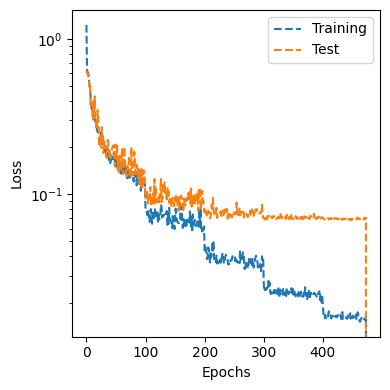

In [70]:
plt.figure(figsize=(4,4))
plt.plot(loss_data[0, :], loss_data[1, :], "--", label="Training")
plt.plot(loss_data[0, :], loss_data[2, :], "--", label="Test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.savefig("Loss.pdf")

In [ ]:
inputX.shape (2001, 1000)
input shape: n_data, n_p, n_features =  torch.Size([1000, 2001, 2])
output shape: n_data, n_p, n_features =  torch.Size([1000, 2001])
1336001
0 1.2769754864275455 1.2290015068054199
1 1.2655905056744814 0.6109203424453735
2 1.2612695842981339 0.6335897636413574
3 1.2621550243347883 0.6006281175613404
4 1.2618746049702168 0.5626185836791993
5 1.2621403746306896 0.5222607107162476
6 1.2730219271034002 0.49057582950592044
7 1.262554807588458 0.42441271018981935
8 1.2626233249902725 0.36574988794326785
9 1.2617833483964205 0.35868933868408204
10 1.2624409943819046 0.36820928382873536
11 1.2618954088538885 0.35663035821914674
12 1.2736786678433418 0.31883122253417967
13 1.2735883630812168 0.2948878765106201
14 1.2730233445763588 0.30287085962295535
15 1.262947954237461 0.2839982061386108
16 1.2616079077124596 0.2614908685684204
17 1.2620172575116158 0.2563236536979675
18 1.2622302528470755 0.2543627030849457
19 1.2621667888015509 0.22525755524635316
20 1.2623597979545593 0.23678826022148133
21 1.2615124080330133 0.23392848634719848
22 1.261983871459961 0.24359435319900513
23 1.262303588911891 0.2316626181602478
24 1.2618738636374474 0.22859281134605408
25 1.2630092930048704 0.21027624535560607
26 1.262610713019967 0.20700006580352784
27 1.2625273205339909 0.20642761325836181
28 1.262385020032525 0.21395028448104858
29 1.2625963725149632 0.19411610698699952
30 1.2624612245708704 0.22683710193634032
31 1.2623217906802893 0.2280777337551117
32 1.2621367052197456 0.19926360630989073
33 1.2624861802905798 0.17522600984573364
34 1.262473275884986 0.1798642041683197
35 1.2627215273678303 0.19459476900100708
36 1.2621179819107056 0.172786634683609
37 1.2624780274927616 0.1798119888305664
38 1.262088706716895 0.15809534406661988
39 1.2639626953750849 0.16025739669799804
40 1.2667140252888203 0.21641678476333617
41 1.2621959447860718 0.16863798689842224
42 1.2622421123087406 0.15231971526145935
43 1.2622897326946259 0.15953378558158873
44 1.2636010516434908 0.1784863793849945
45 1.2629244402050972 0.16393917751312256
46 1.2622866109013557 0.14252410316467284
47 1.2625968344509602 0.14519281625747682
48 1.2619824055582285 0.20129042291641236
49 1.262986546382308 0.1476096796989441
50 1.2619110960513353 0.1400538067817688
51 1.2627837173640728 0.1487449269294739
52 1.2619655411690474 0.16802994155883788
53 1.2622714322060347 0.15752728533744811
54 1.262311153113842 0.1413603458404541
55 1.2626759428530931 0.14781512260437013
56 1.2622420396655798 0.1579893617630005
57 1.2621320374310017 0.1544680006504059
58 1.2621773462742567 0.160315101146698
59 1.2625451013445854 0.14400945281982422
60 1.2623396832495928 0.14459774100780487
61 1.2619785200804472 0.13995775389671325
62 1.2626720145344734 0.12771823573112487
63 1.2631554137915373 0.13412194323539733
64 1.2623070888221264 0.12441997480392455
65 1.2624946553260088 0.11955714774131775
66 1.2621068358421326 0.1323530638217926
67 1.2626296319067478 0.1495828322172165
68 1.2690842393785715 0.15856986355781555
69 1.275641929358244 0.127965136885643
70 1.2626307923346758 0.14373610687255858
71 1.2627437133342028 0.15593470239639282
72 1.2622813265770674 0.11131484460830689
73 1.2627069409936666 0.12682319736480713
74 1.2620663028210402 0.1756188817024231
75 1.263179950416088 0.12028633499145508
76 1.2620818056166172 0.13482933151721954
77 1.2623676341027021 0.12965273094177246
78 1.2622739523649216 0.14299492156505586
79 1.2628772016614676 0.13908583784103393
80 1.2629231754690409 0.11209850609302521
81 1.262634227052331 0.1188886741399765
82 1.262808570638299 0.12342000102996827
83 1.2626240104436874 0.13645556044578552
84 1.2624443396925926 0.14265778863430023
85 1.2623649388551712 0.13652743923664093
86 1.2627110909670591 0.10578770518302917
87 1.266439113765955 0.11503891241550446
88 1.266108887270093 0.11480904185771942
89 1.2627230398356915 0.10330117094516754
90 1.2631907034665346 0.12233317196369171
91 1.262876957654953 0.1140937579870224
92 1.262631382793188 0.1252450190782547
93 1.2627780716866255 0.13501194620132445
94 1.2624075412750244 0.12213128554821015
95 1.262997867539525 0.13186329770088195
96 1.2624008562415838 0.1174586899280548
97 1.2626299764961004 0.10508265876770019
98 1.2622026484459639 0.11342348515987397
99 1.2628694903105497 0.10509985625743866
100 1.262267718091607 0.08699755036830902
101 1.2636337969452143 0.07854922425746917
102 1.2720251325517893 0.0706179759502411
103 1.2629211526364088 0.0705153626203537
104 1.2627869341522455 0.07918265771865844
105 1.2627453580498695 0.06822250521183014
106 1.2625368665903807 0.07522639536857605
107 1.2631768770515919 0.06512375402450561
108 1.2623694688081741 0.07046703642606736
109 1.2625487800687551 0.0737269288301468
110 1.2643480487167835 0.06780389964580535
111 1.2639692034572363 0.07277405846118927
112 1.2626286763697863 0.07023481702804565
113 1.262483013793826 0.07033363711833954
114 1.2622746974229813 0.06593129819631577
115 1.2629487346857786 0.06705173110961914
116 1.2621467281132936 0.07616026711463929
117 1.2627743482589722 0.0735210827589035
118 1.2626117076724768 0.07703520953655243
119 1.2628893982619047 0.07500910770893097
120 1.2622343562543392 0.07466647362709046
121 1.263650581240654 0.07255139768123627
122 1.2620820105075836 0.07495203673839569
123 1.2630408313125372 0.06449606227874756
124 1.2625645715743303 0.07177473556995392
125 1.2732325624674559 0.0672965565919876
126 1.272847881540656 0.07893303680419922
127 1.263042876496911 0.06830827271938324
128 1.2626818846911192 0.07466492861509323
129 1.2623038366436958 0.07233537042140961
130 1.2628565337508917 0.06992090195417404
131 1.2624339926987886 0.06471445477008819
132 1.2626287881284952 0.06163402420282364
133 1.2626044377684593 0.07159146505594254
134 1.2624665312469006 0.0704558892250061
135 1.266780775040388 0.06599637508392334
136 1.2646351121366024 0.06954672813415527
137 1.2623350135982037 0.06594347929954529
138 1.2623643893748522 0.06637865447998047
139 1.2630674317479134 0.07213959789276123
140 1.2626983560621738 0.07856817209720611
141 1.2621371373534203 0.06685920095443726
142 1.2622562013566494 0.071974511384964
143 1.2627916671335697 0.0669181501865387
144 1.2630698215216398 0.07518689841032028
145 1.2625480629503727 0.06716369867324828
146 1.2623470611870289 0.0770663520693779
147 1.2625967636704445 0.07748305976390839
148 1.26280028373003 0.07012064218521118
149 1.2624244913458824 0.06836013895273209
150 1.2625091802328825 0.06877662968635559
151 1.2628258559852839 0.06588565593957901
152 1.262370340526104 0.07586032783985137
153 1.262410718947649 0.0799689177274704
154 1.2622574232518673 0.05938526582717896
155 1.2628367468714714 0.06879870277643203
156 1.2620191406458616 0.06015423387289047
157 1.2620212733745575 0.0703979790210724
158 1.2630230356007814 0.06205040687322617
159 1.2629617545753717 0.07819005906581879
160 1.2624557595700026 0.0675148559808731
161 1.262019831687212 0.06844794303178788
162 1.263319592922926 0.06708814799785615
163 1.2625578679144382 0.06761242479085922
164 1.2626714278012514 0.058777682662010194
165 1.262388613075018 0.05721940362453461
166 1.261889323592186 0.06989240020513535
167 1.2631769739091396 0.06731837975978851
168 1.262452069669962 0.06736531698703765
169 1.2625011950731277 0.06905464446544647
170 1.2628291100263596 0.06762749612331391
171 1.2629557102918625 0.057603248596191405
172 1.263063844293356 0.07605765491724015
173 1.2624869085848331 0.06606139481067658
174 1.2622377406805754 0.05914140874147415
175 1.2629907336086035 0.07086720532178879
176 1.2627803795039654 0.06629545098543167
177 1.2621891126036644 0.07008137762546539
178 1.264117382466793 0.05981376874446869
179 1.2628559675067663 0.06047604066133499
180 1.2637785635888577 0.05897627931833267
181 1.276933815330267 0.060417864620685574
182 1.26745112426579 0.0717336939573288
183 1.2675320208072662 0.06038075751066208
184 1.263922467827797 0.05630339246988297
185 1.2627286817878485 0.06882878535985947
186 1.2622180432081223 0.07215538889169693
187 1.2626165598630905 0.06603860104084015
188 1.262993510812521 0.06849007332324981
189 1.2625034395605326 0.0761184538602829
190 1.2622296325862408 0.06309887945652008
191 1.2623711600899696 0.06811257022619248
192 1.2626448925584555 0.06279042917490006
193 1.2622587624937296 0.05542979246377945
194 1.262136660516262 0.05726816618442535
195 1.2624163758009672 0.05835971760749817
196 1.2628085874021053 0.06244818043708801
197 1.2624968513846397 0.06049450087547302
198 1.2674119547009468 0.07132467824220658
199 1.2625136487185955 0.05783117651939392
200 1.262654148042202 0.04747566419839859
201 1.2649434059858322 0.04230975091457367
202 1.2623439151793718 0.04045119971036911
203 1.262476535513997 0.038463653981685636
204 1.2622045371681452 0.04044013899564743
205 1.2629662230610847 0.03849876701831818
206 1.262357136234641 0.036436193585395814
207 1.262837192043662 0.03825752425193787
208 1.2622500732541084 0.04052789556980133
209 1.262604145333171 0.042734959483146664
210 1.2624558378010988 0.04307241725921631
211 1.2622944917529821 0.03753433132171631
212 1.2627234049141407 0.03729211664199829
213 1.2628191243857145 0.03915287858247757
214 1.2620449848473072 0.038483164608478546
215 1.2625856827944517 0.0369731662273407
216 1.2626647800207138 0.0365474933385849
217 1.2621257547289133 0.03516055124998092
218 1.2619263753294945 0.03765347677469254
219 1.2626461908221245 0.03745389848947525
220 1.2621928751468658 0.04250627326965332
221 1.2629235871136189 0.045734813749790194
222 1.262509074062109 0.03853970181941986
223 1.262591939419508 0.03728947877883911
224 1.2624662425369024 0.0361307555437088
225 1.2628250233829021 0.038174003541469576
226 1.2629169896245003 0.03589439409971237
227 1.262184577062726 0.03850747621059418
228 1.2622457556426525 0.03430195471644402
229 1.2623855974525213 0.04208526867628098
230 1.2621158864349127 0.03703520041704178
231 1.2678955402225256 0.04261526596546173
232 1.263615295290947 0.04121326494216919
233 1.262519458308816 0.03808723789453507
234 1.2628631312400103 0.03359615203738213
235 1.2628744207322598 0.037714991867542264
236 1.262935884296894 0.035774803459644317
237 1.2764683421701193 0.038301617681980135
238 1.2683122660964727 0.03801427775621414
239 1.2620400208979845 0.035038607239723206
240 1.2626998014748096 0.03580940300226212
241 1.2621752303093672 0.03887323898077011
242 1.2626131027936935 0.03613062196969986
243 1.2622462455183268 0.034390811741352084
244 1.2622129153460264 0.03630871075391769
245 1.2623276393860579 0.035281290352344515
246 1.2624961994588375 0.037350488901138304
247 1.2628204934298992 0.03807131564617157
248 1.2625472377985716 0.036122308433055875
249 1.262492123991251 0.03549555844068527
250 1.263165194541216 0.041287856280803684
251 1.2621872685849667 0.03769519650936127
252 1.2630178891122341 0.037600595653057095
253 1.26223349198699 0.03531316095590591
254 1.2625550478696823 0.03749402111768722
255 1.2624703720211983 0.040852661550045015
256 1.262122593820095 0.038904994904994966
257 1.262278726324439 0.03614351785182953
258 1.262561159208417 0.03707142299413681
259 1.2624242044985294 0.040976607620716095
260 1.2620752025395632 0.03996208053827286
261 1.2626531422138214 0.0371662967801094
262 1.2623239289969206 0.03741763734817505
263 1.261793939396739 0.035151435554027555
264 1.26281363889575 0.03587554663419724
265 1.2626672238111496 0.035908694148063657
266 1.2628121878951788 0.036415308713912964
267 1.2618164010345936 0.03696329063177109
268 1.262517124414444 0.03747798430919647
269 1.2627231515944004 0.04275329554080963
270 1.2633017972111702 0.035201981246471406
271 1.2627725936472416 0.03501666897535324
272 1.2628710065037012 0.03722899156808853
273 1.2624952401965857 0.037564468681812284
274 1.2628528382629156 0.03729118585586548
275 1.2624262608587742 0.037602353632450104
276 1.2626695353537798 0.033180923402309416
277 1.262494284659624 0.035837132155895235
278 1.2633845768868923 0.04079761534929276
279 1.2671072985976934 0.03964252185821533
280 1.2627448122948408 0.040045623540878296
281 1.2626069281250238 0.038272321224212646
282 1.262074427679181 0.040908147275447844
283 1.2628350052982569 0.03619105035066605
284 1.2620292529463768 0.03651089745759964
285 1.262841546908021 0.03474190127849579
286 1.262661388143897 0.03472720015048981
287 1.2623754665255547 0.034578976333141324
288 1.2625625096261501 0.03474952673912048
289 1.262250792235136 0.03636503940820694
290 1.262396678328514 0.041645063042640686
291 1.2626224495470524 0.037185733735561374
292 1.2678161766380072 0.037850694000720976
293 1.2787971533834934 0.03548096889257431
294 1.264827262610197 0.032297183573246
295 1.2625636719167233 0.036963447630405426
296 1.2626301050186157 0.03348358792066574
297 1.2630404904484749 0.03781601327657699
298 1.2620010878890753 0.037855129837989804
299 1.262893207371235 0.034414137363433836
300 1.2626434490084648 0.029166536182165147
301 1.2639285456389189 0.025196756809949875
302 1.262656832113862 0.024637958258390425
303 1.2625425476580858 0.0241935758292675
304 1.262650988996029 0.023664450138807296
305 1.2621711865067482 0.024623534828424453
306 1.2623265199363232 0.023777013033628464
307 1.262307709082961 0.022930528432130812
308 1.262307021766901 0.02342810907959938
309 1.2624438218772411 0.02544738322496414
310 1.2618324682116508 0.02423687446117401
311 1.262253886088729 0.02303419104218483
312 1.262508636340499 0.02438373678922653
313 1.2622832655906677 0.024050834536552428
314 1.2618714272975922 0.02388233184814453
315 1.2621987592428923 0.02250767794251442
316 1.2620750553905964 0.022435381978750227
317 1.2623053267598152 0.023299920529127122
318 1.2628611326217651 0.02351589232683182
319 1.2621478978544474 0.024657028794288636
320 1.261694585904479 0.023216920793056487
321 1.262244950979948 0.023335839539766312
322 1.262154072523117 0.02383626455068588
323 1.2629393618553877 0.024781469464302062
324 1.2620035875588655 0.02274752488732338
325 1.2619206197559834 0.023073644638061525
326 1.2657212000340223 0.0231405728161335
327 1.2660864274948835 0.02391440612077713
328 1.262444881722331 0.02268053075671196
329 1.262216679751873 0.024259384721517563
330 1.2655273992568254 0.02451870611310005
331 1.2623218726366758 0.024885349333286285
332 1.2625210788100958 0.022782510548830032
333 1.2618855386972427 0.022523075491189957
334 1.2621466405689716 0.02266229212284088
335 1.2618314363062382 0.022489590674638748
336 1.2626586128026247 0.02481934905052185
337 1.2624365128576756 0.023805377453565597
338 1.2624618615955114 0.022127653002738952
339 1.2619895711541176 0.023256364971399306
340 1.2625045031309128 0.022507666438817978
341 1.2640791349112988 0.024978252917528154
342 1.2658338453620672 0.021880516558885576
343 1.2622277047485113 0.022927962511777877
344 1.2627460304647684 0.021927128434181212
345 1.262345377355814 0.02292573168873787
346 1.2620585914701223 0.02469067794084549
347 1.263281062245369 0.02314900252223015
348 1.263110600411892 0.024590501338243486
349 1.277316216379404 0.02272708085179329
350 1.2679699901491404 0.02373913577198982
351 1.2621034514158964 0.026451838850975035
352 1.2626664079725742 0.02391056913137436
353 1.262122306972742 0.023240349113941194
354 1.262992398813367 0.025322090804576872
355 1.2618092577904463 0.02431358128786087
356 1.2621624413877726 0.02210357317328453
357 1.2626264803111553 0.02197729530930519
358 1.2618597652763128 0.022874444544315337
359 1.2618076801300049 0.02236431610584259
360 1.2623625360429287 0.024119682282209395
361 1.261987702921033 0.024992287009954452
362 1.2635584641247988 0.023049587100744246
363 1.2624478992074728 0.02264768984913826
364 1.2624914199113846 0.02329078459739685
365 1.2628682740032673 0.023444744020700455
366 1.2628874368965626 0.023125824719667433
367 1.2619959749281406 0.024981420546770095
368 1.2616775278002024 0.021575821578502654
369 1.2621340621262789 0.021935173392295837
370 1.2634071595966816 0.023598611533641817
371 1.2627064641565084 0.023777129024267197
372 1.2619241066277027 0.022686339020729064
373 1.2618332151323557 0.023658895552158356
374 1.2649386562407017 0.023418055683374406
375 1.2657360527664423 0.02545504331588745
376 1.2626943048089743 0.023321334570646286
377 1.2619855683296919 0.021916282713413237
378 1.2619627956300974 0.021856584399938584
379 1.2626374699175358 0.021643918842077257
380 1.262040751054883 0.026344893097877502
381 1.2627890724688768 0.02573661670088768
382 1.2624912317842245 0.026503272265195846
383 1.262245949357748 0.0247575798034668
384 1.2623779457062483 0.02099353975057602
385 1.262753026559949 0.02072550630569458
386 1.262229859828949 0.02152900430560112
387 1.2630255706608295 0.02249984458088875
388 1.271433925256133 0.0209748375415802
389 1.2672726567834616 0.020937387615442275
390 1.2626027893275023 0.02197470536828041
391 1.2624273095279932 0.021586342096328735
392 1.262399671599269 0.02282557052373886
393 1.2624684739857912 0.021511864125728607
394 1.2617783714085817 0.020923465758562087
395 1.2632031682878733 0.02180349028110504
396 1.2621438596397638 0.02285091856122017
397 1.2619872018694878 0.022192596912384035
398 1.2628121133893728 0.021478795051574708
399 1.262349808588624 0.022492062091827393
400 1.269165724515915 0.018864040106534957
401 1.2673858888447285 0.017364542752504347
402 1.2633568681776524 0.016797723442316056
403 1.2634353656321764 0.016792004078626632
404 1.2677160520106554 0.016308924973011018
405 1.2761924788355827 0.01667558181285858
406 1.263917027041316 0.01631378674507141
407 1.2629873026162386 0.016267185300588606
408 1.2631098330020905 0.016253245532512665
409 1.2621891479939222 0.016283861666917802
410 1.2634808272123337 0.0157475928068161
411 1.2626657411456108 0.01597094814479351
412 1.2637189161032438 0.01616948390007019
413 1.2630310375243425 0.016170872449874876
414 1.2623124364763498 0.016285410284996034
415 1.2621645089238882 0.016399777352809907
416 1.2618885170668364 0.016904145359992982
417 1.2619689851999283 0.017187794536352156
418 1.2623301222920418 0.016706276148557662
419 1.2624125387519598 0.016823496878147125
420 1.262030879035592 0.017300230532884597
421 1.2619234472513199 0.017176565110683443
422 1.2664546053856611 0.016973330199718476
423 1.2651632707566023 0.017309928268194198
424 1.262965314090252 0.016166035175323487
425 1.2623637150973082 0.016569904118776322
426 1.2625054772943258 0.01675278803706169
427 1.262215731665492 0.01656871336698532
428 1.2626067083328962 0.016192278906702995
429 1.2625405583530664 0.0161362184882164
430 1.262303562834859 0.017760213762521744
431 1.262514304369688 0.01668118295073509
432 1.2623543478548527 0.016240735560655594
433 1.2623932491987944 0.016956205397844315
434 1.2626017685979605 0.016664197951555253
435 1.2625744715332985 0.01646061834692955
436 1.2625013422220945 0.016658316165208818
437 1.2620196994394064 0.016959646970033646
438 1.2620147336274385 0.016991343379020692
439 1.2623747941106558 0.016899013102054595
440 1.2622470427304506 0.0167158205807209
441 1.2619197089225054 0.016508957862854005
442 1.2633817475289106 0.016862131506204605
443 1.2621231246739626 0.016159628227353097
444 1.2621323205530643 0.01606559592485428
445 1.2624267525970936 0.016269969522953034
446 1.2619381994009018 0.01583791747689247
447 1.2621769327670336 0.01684562635421753
448 1.2632797993719578 0.017102764904499055
449 1.2627977672964334 0.018116326212882995
450 1.2630229145288467 0.01705100730061531
451 1.2632657904177904 0.01555039742588997
452 1.2682075593620539 0.015769742369651795
453 1.2623566128313541 0.01614151492714882
454 1.2621977739036083 0.015926816090941428
455 1.2622257489711046 0.01683589857816696
456 1.2624440416693687 0.01621162295341492
457 1.2626137100160122 0.016373955994844435
458 1.2625715490430593 0.015747967898845673
459 1.262654136866331 0.016830703049898147
460 1.26532350666821 0.01655836397409439
461 1.270916122943163 0.015712623089551927
462 1.2755082044750452 0.016316461592912675
463 1.2621185071766376 0.016091969072818756
464 1.2621596287935972 0.016149135798215867
465 1.2623011507093906 0.016337413281202317
466 1.2646362893283367 0.01666674271225929
467 1.2624299433082342 0.01574782022833824
468 1.2622801829129457 0.015589588731527328
469 1.262721249833703 0.016087568670511247
470 1.2666998822242022 0.016393776506185533
471 1.2642947155982256 0.01583937844634056
472 1.2649755142629147 0.016204843550920486
473 1.2623804286122322 0.01615768188238144
474 1.2622135858982801 0.015927877247333525
475 1.2624341864138842 0.015107318311929702
476 1.2627665027976036 0.01584788128733635
477 1.2623462043702602 0.016285590320825577
478 1.262532938271761 0.01572054532170296
479 1.261926431208849 0.015442220866680146
480 1.2625760585069656 0.016162643998861314
481 1.262512482702732 0.015620307475328445
482 1.262262249365449 0.016489864706993103
483 1.2703329306095839 0.01627485278248787
484 1.264107732102275 0.01574581488966942
485 1.2627938222140074 0.015643254056572915
486 1.2630989998579025 0.01554444432258606
487 1.2627988923341036 0.015697955891489982
488 1.2626616340130568 0.015816352024674414
489 1.2624307088553905 0.015229313552379609
490 1.2635465059429407 0.015109439447522164
491 1.2668531574308872 0.01586209973692894
492 1.2621849738061428 0.01559805628657341
493 1.262311914935708 0.015206528931856155
494 1.2629866618663073 0.01515093159675598
495 1.2622569389641285 0.01645898738503456
496 1.2627584394067526 0.01577937090396881
497 1.2631080988794565 0.015537590101361274
498 1.2628729231655598 0.015790315717458724
499 1.263529798015952 0.015596340149641038
500 1.2625166587531567 0.014247693628072738
501 1.26359486207366 0.013506023466587067
502 1.2626001480966806 0.013226519420742988
503 1.2627001367509365 0.013144483268260955
504 1.2625673599541187 0.013034758910536766
505 1.2621384169906378 0.013146809250116348
506 1.2626972794532776 0.012947836697101592
507 1.266923287883401 0.013033931910991668
508 1.2651666924357414 0.013354462817311287
509 1.2648974992334843 0.013543213576078414
510 1.2646499332040548 0.013128652453422547
511 1.2638147119432688 0.013431657433509827
512 1.2641180492937565 0.013239174276590347
513 1.2653758954256773 0.013390571564435958
514 1.2658876068890095 0.013262505173683166
515 1.2644733916968107 0.013253516882658006
516 1.264702957123518 0.01328807596862316
517 1.2707440089434385 0.013145798817276955
518 1.2840049397200346 0.01320890174806118
519 1.2732942271977663 0.013286922618746758
520 1.267510175704956 0.013099258944392204
521 1.2645514123141766 0.013384248718619346
522 1.2645440511405468 0.013476004913449288
523 1.2688066214323044 0.013338004916906357
524 1.2649306431412697 0.013081135407090187
525 1.2641488127410412 0.013485435262322426
526 1.265087341889739 0.013194995924830437
527 1.2639621440321207 0.013082360327243804
528 1.2643047105520964 0.01316083088517189
529 1.265536479651928 0.013222896739840508
530 1.2650110125541687 0.013295700922608376
531 1.2645459901541471 0.013602287217974662
532 1.2647126447409391 0.013441652327775956
533 1.264440905302763 0.013647321447730064
534 1.264978788793087 0.01362644661962986
535 1.2645854353904724 0.013587481230497361
536 1.2648794315755367 0.01311113677918911
537 1.2659820355474949 0.013021741509437561
538 1.2652182653546333 0.01278253734111786
539 1.2648165579885244 0.01265230792760849
540 1.2652487494051456 0.012739549279212952
541 1.2643664684146643 0.013269649997353554
542 1.2645330913364887 0.013202887952327729
543 1.264631224796176 0.01331471498310566
544 1.26462946459651 0.013471153438091278
545 1.26416096650064 0.013398800641298295
546 1.2642638646066189 0.01322051228582859
547 1.2647486999630928 0.01341093936562538
548 1.2642356231808662 0.013148127779364586
549 1.264404160901904 0.013070823222398758
550 1.2649188693612814 0.012828925088047982
551 1.2645702790468931 0.012770952939987182
552 1.2644179724156857 0.013133424580097199
553 1.2662548795342445 0.013562523663043976
554 1.2700575198978186 0.013956427618861199
555 1.2662587743252516 0.013175062283873558
556 1.2642493415623903 0.012912741482257843
557 1.264805031940341 0.01275779166817665
558 1.2642762251198292 0.013007991507649422
559 1.2641850765794516 0.0133446656614542
560 1.2646746598184109 0.012796658083796502
561 1.2684033159166574 0.01258397801220417
562 1.2645719349384308 0.01272247065603733
563 1.2644272968173027 0.012844865143299102
564 1.264519389718771 0.0126916516572237
565 1.2642225753515959 0.012767862096428871
566 1.2681238576769829 0.012707243725657463
567 1.2688031401485205 0.012878210753202439
568 1.2661037631332874 0.012823083057999611
569 1.267285579815507 0.012944225743412972
570 1.2648609057068825 0.013075727209448815
571 1.2648063916713 0.012872763887047767
572 1.2636927720159292 0.012986414656043053
573 1.2640781346708536 0.01284803782403469
574 1.2645905707031488 0.012772883549332618
575 1.2645414397120476 0.01280749636888504
576 1.2703902032226324 0.012794574648141861
577 1.2778636999428272 0.012844013005495071
578 1.2708112485706806 0.013098097845911979
579 1.264714227989316 0.01314746980369091
580 1.2644658405333757 0.012739118158817292
581 1.2645119465887547 0.012699909314513206
582 1.2649073097854853 0.012910513252019883
583 1.3627743609249592 0.01298024933040142
584 2.350444981828332 0.013077789261937142
585 2.3446696493774652 0.012767908796668052
586 2.1997672226279974 0.0127484969496727
587 2.3629533648490906 0.013281981542706489
588 2.4119031447917223 0.013359522178769111
589 2.415117461234331 0.012770385369658471
590 2.450954223051667 0.013231348603963852
591 2.46541615575552 0.01327043117582798
592 2.4984145518392324 0.013203112050890923
593 2.4343845900148153 0.012711923018097877
594 2.284294193610549 0.012618312507867813
595 2.4791476130485535 0.012308679953217506
596 2.36247911863029 0.012396251037716865
597 2.4558121133595705 0.012500778242945671
598 2.480792038142681 0.01236692464351654
599 2.4462060891091824 0.012792246580123902
600 2.3155053481459618 0.01201593655347824
601 2.43297110311687 0.011718763798475265
602 2.4539385940879583 0.011640714570879937
603 2.269961418583989 0.011631529197096825
604 2.4267421308904886 0.01167507265508175
605 2.437051711603999 0.011677869975566864
606 2.440210761502385 0.01159165984392166
607 2.4449580684304237 0.011584219932556152
608 2.386605555191636 0.011602847889065742
609 2.425951551645994 0.011639100059866906
610 2.3647489603608847 0.011577635437250138
611 2.4572264812886715 0.011548564195632934
612 2.4176178108900785 0.011555465668439865
613 2.36120150052011 0.011698105439543725
614 2.447429768741131 0.01171270589530468
615 2.3797179982066154 0.011596807360649108
616 2.3996931444853544 0.011555978938937186
617 2.3622364699840546 0.01168229879438877
618 2.4517275728285313 0.01162580582499504
619 2.3775724191218615 0.01162687847018242
620 2.365622900426388 0.011689163982868194
621 2.395219476893544 0.01162637448310852
622 2.299294026568532 0.011594650119543075
623 2.415045903995633 0.011626870691776276
624 2.4170880503952503 0.011685167148709296
625 2.4893932696431875 0.01164450678229332
626 2.447918802499771 0.011600849106907845
627 2.436816396191716 0.011563780650496482
628 2.453085169196129 0.011553389757871627
629 2.4610363617539406 0.011589906886219978
630 2.4471364207565784 0.011593713983893394
631 2.4607198014855385 0.011704766884446145
632 2.5216965451836586 0.01186097565293312
633 2.4168695751577616 0.011711529359221458
634 2.4677356090396643 0.011684750318527221
635 2.4467631559818983 0.011615568205714227
636 2.4544952865689993 0.011583462044596673
637 2.355113685131073 0.011538044676184654
638 2.4427586030215025 0.011554548755288123
639 2.4016486648470163 0.011503382548689843
640 2.444839144125581 0.011601938590407371
641 1.556144466623664 0.011679128840565682
642 1.2786277346313 0.011607355788350105
643 1.2710091099143028 0.011628583908081054
644 1.2641167771071196 0.011636292621493339
645 1.2647367361932993 0.011535327613353729
646 1.2642262298613787 0.011573711454868317
647 1.264765789732337 0.011431141570210458
648 1.2651994936168194 0.011454350501298904
649 1.2646936234086752 0.011533855259418488
650 1.2641111835837364 0.011574965119361878
651 1.2647727075964212 0.011639662891626358
652 1.2642437610775232 0.011489308685064316
653 1.2643116246908903 0.011507106184959412
654 1.2646220065653324 0.011643248975276948
655 1.2639930620789528 0.011496018722653389
656 1.264251708984375 0.011504782289266586
657 1.2647079154849052 0.011552227154374123
658 1.2663029041141272 0.01148586630821228
659 1.2650395706295967 0.011507641479372978
660 1.2642405033111572 0.011389521017670632
661 1.265796096995473 0.011488500490784644
662 1.2636685241013765 0.011447757944464683
663 1.2646304909139872 0.011409187942743301
664 1.264196664094925 0.011356614693999291
665 1.2642907723784447 0.011448157653212547
666 1.264810973778367 0.011479437991976737
667 1.2641995325684547 0.011498295307159423
668 1.2646173816174269 0.011461739674210549
669 1.2642461229115725 0.011403162032365799
670 1.2644291389733553 0.011497232228517533
671 1.2645650897175074 0.011445450782775878
672 1.269132250919938 0.011500526323914528
673 1.2656427770853043 0.011592715218663216
674 1.2702960539609194 0.011474266186356545
675 1.2679670806974173 0.01131485004723072
676 1.264762593433261 0.011436959654092789
677 1.264058955013752 0.011385562807321548
678 1.3899764269590378 0.011280912891030311
679 1.8494388554245234 0.011258697897195816
680 1.8853609543293715 0.011303863048553468
681 1.3045627772808075 0.01124669836461544
682 1.264349028468132 0.011534530386328698
683 1.2645135093480349 0.011557353988289833
684 1.2636360973119736 0.011381540134549142
685 1.2652825433760881 0.011320009738206863
686 1.263761518523097 0.011575162068009376
687 1.264455048367381 0.011505268514156342
688 1.264466766268015 0.011391717463731766
689 1.264035003259778 0.01134335358440876
690 1.2638903632760048 0.011304119631648063
691 1.2644223310053349 0.011375700131058692
692 1.2643556110560894 0.011282548502087594
693 1.6210963912308216 0.011176239132881165
694 1.8234887551516294 0.01112567175924778
695 1.7179972287267447 0.01125379654765129
696 1.2646292075514793 0.011379955932497979
697 1.2637286428362131 0.011191065818071366
698 1.2765907272696495 0.011340647354722023
699 1.2751103602349758 0.011288049533963203
700 1.2637787256389856 0.011034483537077904
701 1.2650831528007984 0.010926761358976364
702 1.2672676239162683 0.010884482324123382
703 1.2644578218460083 0.010878559067845345
704 1.264014944434166 0.010886673539876938
705 1.2638709917664528 0.010877479508519172
706 1.2647269517183304 0.01085763680934906
707 1.2642583828419447 0.010874400720000267
708 1.266183765605092 0.01087164780497551
709 1.2641710489988327 0.010847411617636681
710 1.2639660332351923 0.010859165504574777
711 1.263695027679205 0.010846038863062858
712 1.2644197028130293 0.010841090142726897
713 1.263775434345007 0.010847122609615326
714 1.2745633069425821 0.010847902446985245
715 1.2641108632087708 0.010831587567925453
716 1.2637933976948261 0.010831990242004395
717 1.2635529953986406 0.010837077900767326
718 1.264224998652935 0.010896187290549279
719 1.2649980634450912 0.010824317395687103
720 1.2896296568214893 0.01083363188803196
721 1.2673572283238173 0.01093215000629425
722 1.2680301554501057 0.010867576569318771
723 1.2648808639496565 0.010820909932255745
724 1.2641049791127443 0.010823708027601242
725 1.2687534466385841 0.01081464758515358
726 1.2639979124069214 0.010945042431354522
727 1.2647449541836977 0.010831709176301956
728 1.2643245607614517 0.010845972537994384
729 1.2634887862950563 0.010806411549448967
730 1.26571149751544 0.010798146709799767
731 1.2656565867364407 0.0108215511739254
732 1.263971408829093 0.010829734429717065
733 1.2639591339975595 0.010823925212025642
734 1.2647909596562386 0.010861208632588387
735 1.2643125485628843 0.010811946049332619
736 1.264651995152235 0.010814829513430595
737 1.2642269413918257 0.01084527949988842
738 1.2641969174146652 0.01080184656381607
739 1.2642813939601183 0.01085898531973362
740 1.2636429648846388 0.010798907622694968
741 1.2639738377183676 0.010841319873929023
742 1.263909224420786 0.01084396229684353
743 1.2644395362585783 0.010797168061137199
744 1.2711285930126905 0.01083957551419735
745 1.2636917773634195 0.010851952821016312
746 1.2642798479646444 0.010754717960953713
747 1.2636490799486637 0.010806908011436462
748 1.264200683683157 0.010747456774115562
749 1.2639937475323677 0.010740497693419457
750 1.2685620840638876 0.01076194640994072
751 1.263570697978139 0.01080922044813633
752 1.2639236766844988 0.010760341286659241
753 1.2637380994856358 0.010749691441655159
754 1.2639875560998917 0.010768266588449479
755 1.2641339153051376 0.010749974086880684
756 1.2659906279295683 0.010722504511475562
757 1.2781961560249329 0.010712847009301186
758 1.2927473355084658 0.010725590139627457
759 1.2642476987093687 0.01074029941856861
760 1.2645998895168304 0.010692211240530014
761 1.264130413532257 0.010698628276586533
762 1.2658024802803993 0.010695853605866432
763 1.2648622374981642 0.010699992030858994
764 1.264245267957449 0.010751205235719681
765 1.2640872411429882 0.010826032653450966
766 1.2646272871643305 0.010725955054163933
767 1.2654066924005747 0.010726689577102662
768 1.2653070129454136 0.01072784547507763
769 1.269593147560954 0.010723303809762
770 1.2690092623233795 0.010793560668826103
771 1.26418231241405 0.010720145851373673
772 1.2644951548427343 0.010719254031777382
773 1.2640933115035295 0.010701671749353409
774 1.2644605841487646 0.010698670968413353
775 1.264157583937049 0.010654003858566284
776 1.2644156590104103 0.010658987194299698
777 1.2642278634011745 0.010680013418197631
778 1.2643889393657446 0.010689948946237563
779 1.2647442799061537 0.01072083768248558
780 1.2645777072757483 0.010655810058116912
781 1.2646345291286707 0.010664022326469421
782 1.2693441826850176 0.010635433912277222
783 1.2640900295227766 0.010715323254466056
784 1.2646400183439255 0.010655748710036278
785 1.2645915150642395 0.010666836887598037
786 1.2644307799637318 0.010618564650416374
787 1.2644029315561056 0.010675001963973045
788 1.2642420772463083 0.010659350216388702
789 1.2658330593258142 0.010613696292042733
790 1.265030924230814 0.010598161280155182
791 1.2658657748252153 0.010655397653579712
792 1.2645485755056143 0.010667731747031213
793 1.2640250325202942 0.010638728976249694
794 1.263983367010951 0.010656867146492005
795 1.2643241714686155 0.010604983374476433
796 1.2640456333756447 0.010617696419358254
797 1.265618672594428 0.010593597039580346
798 1.2703088354319334 0.010604324445128441
799 1.2645859997719526 0.010643730625510215
800 1.2644465528428555 0.01049566949903965
801 1.265256678685546 0.010475809171795846
802 1.265042718499899 0.010465454280376435
803 1.2673517353832722 0.010455810546875
804 1.2644920572638512 0.010461044698953629
805 1.2643174827098846 0.010448202803730964
806 1.2684711888432503 0.010458947747945785
807 1.2653495389968157 0.010460165649652482
808 1.264764403924346 0.010453431352972985
809 1.2696415539830923 0.010452001348137856
810 1.2647350318729877 0.010449230611324311
811 1.2644876930862665 0.010455297872424125
812 1.2642075959593058 0.010441222310066223
813 1.2645491156727076 0.010441935643553734
814 1.2650925870984793 0.010474241316318512
815 1.2781116180121899 0.010449755385518074
816 1.2719752565026283 0.010445621460676194
817 1.2654480934143066 0.010441665798425674
818 1.2709564808756113 0.010457444712519645
819 1.2666717916727066 0.010428742468357087
820 1.2637942545115948 0.010425349310040475
821 1.2641712818294764 0.010425445541739464
822 1.2648819796741009 0.010430274099111557
823 1.2642317283898592 0.010429168984293937
824 1.2643550615757704 0.010418268620967865
825 1.2637104075402021 0.010434809178113937
826 1.2648878954350948 0.010425393596291542
827 1.264499669894576 0.0104317676872015
828 1.2643882278352976 0.01041357672214508
829 1.2646103203296661 0.010449298232793808
830 1.2647747565060854 0.01042290310561657
831 1.2640389502048492 0.010417535498738289
832 1.265232440084219 0.010416286185383797
833 1.2641195319592953 0.010410538867115975
834 1.2682950552552938 0.010417540997266769
835 1.265221007168293 0.010398462295532226
836 1.2646563332527876 0.010397721543908119
837 1.2639710512012243 0.0103952816426754
838 1.2649886719882488 0.010395239785313606
839 1.2644668240100145 0.010407210156321525
840 1.2659474853426218 0.010409957587718963
841 1.2642706856131554 0.010387250959873199
842 1.2723374124616385 0.010416496321558952
843 1.2649163138121367 0.01040049183368683
844 1.265922537073493 0.01039741589128971
845 1.2640602346509695 0.010390808939933776
846 1.2699377536773682 0.01040559495985508
847 1.2651434615254402 0.010387775346636772
848 1.2641998995095491 0.010396979451179504
849 1.2640765756368637 0.010382190525531769
850 1.2639118675142527 0.010371839106082916
851 1.2646639551967382 0.010392330631613732
852 1.264281453564763 0.010359510093927384
853 1.264188101515174 0.010377426832914352
854 1.2644067611545324 0.010387780815362931
855 1.2647675834596157 0.01037931327521801
856 1.2649850640445948 0.010373990371823311
857 1.26470479182899 0.010361823424696923
858 1.2642889562994242 0.010403962627053261
859 1.2646250315010548 0.010357525497674942
860 1.2637262549251318 0.010359136253595353
861 1.2648564111441374 0.010360543996095657
862 1.2656715400516987 0.010382647410035133
863 1.2648548167198896 0.010349734202027321
864 1.2641072757542133 0.010370249226689339
865 1.2696788888424635 0.010354029133915902
866 1.2711897641420364 0.01035348555445671
867 1.266903780400753 0.010339658007025718
868 1.2641745135188103 0.01034951801598072
869 1.2640311140567064 0.010334329068660737
870 1.2699974905699492 0.010338160708546639
871 1.2639489099383354 0.010332344695925713
872 1.2645784318447113 0.010336968809366227
873 1.2739283479750156 0.010365053653717041
874 1.2770336885005236 0.010341792285442353
875 1.2647200841456652 0.010345010533928872
876 1.2645729575306177 0.010313313707709312
877 1.2643828392028809 0.010324833691120147
878 1.263968586921692 0.0103264319896698
879 1.2650154121220112 0.01032726387679577
880 1.2642636895179749 0.010324815213680267
881 1.2641903180629015 0.010312130495905876
882 1.264118080958724 0.010324324384331703
883 1.2637152094393969 0.010316449254751205
884 1.2641284316778183 0.0103090800344944
885 1.26443275436759 0.010319092065095901
886 1.2645179443061352 0.010297727510333062
887 1.2642678692936897 0.010308072164654732
888 1.2645635083317757 0.010303709238767623
889 1.2638320121914148 0.010299659296870232
890 1.2654980849474669 0.010293943300843239
891 1.2642125450074673 0.010316252082586288
892 1.265390107408166 0.010298158079385757
893 1.264294734224677 0.010297043725848198
894 1.2647375967353582 0.010297472104430199
895 1.2659623250365257 0.01028998365998268
896 1.263860683888197 0.010278237909078598
897 1.2676427140831947 0.010290123984217643
898 1.2641318310052156 0.01027962726354599
899 1.2645791117101908 0.010296182900667191
900 1.2641871627420187 0.010232243686914444
901 1.2646957710385323 0.010229001507163047
902 1.2623758800327778 0.01023370361328125
903 1.2627194356173277 0.010225903496146202
904 1.2624222431331873 0.010226276829838753
905 1.2623463198542595 0.010226429924368858
906 1.2620950490236282 0.010228857934474945
907 1.262484224513173 0.010218607395887374
908 1.2634492348879576 0.010216440543532372
909 1.2660176306962967 0.010225459218025208
910 1.2622526921331882 0.010220262929797172
911 1.2624929435551167 0.010231925651431084
912 1.2623214349150658 0.010216158226132394
913 1.262063141912222 0.010219979956746101
914 1.2668085359036922 0.010221272617578506
915 1.2668244745582342 0.010220464006066323
916 1.2623227797448635 0.010214925572276115
917 1.262033622711897 0.01020652225613594
918 1.261933458968997 0.010210796371102332
919 1.2622098103165627 0.010206943735480308
920 1.2627013996243477 0.010212633028626442
921 1.26233971118927 0.010209808424115181
922 1.2620155066251755 0.010201961666345596
923 1.262171920388937 0.010205894887447357
924 1.2624105848371983 0.010205697938799859
925 1.2623821254819632 0.010206601202487946
926 1.2633265051990747 0.01020122793316841
927 1.2623414359986782 0.01020981954038143
928 1.2627725526690483 0.01020082649588585
929 1.2625944055616856 0.010206768572330474
930 1.269987916573882 0.010197556555271148
931 1.2755821365863085 0.010195337429642678
932 1.2622306533157825 0.010193674221634865
933 1.262636186555028 0.010190799638628959
934 1.262543374672532 0.010193131268024444
935 1.2623374983668327 0.010194146260619163
936 1.2626650147140026 0.010195359781384469
937 1.2626494280993938 0.010192461639642715
938 1.2624832838773727 0.010192836210131645
939 1.2622459158301353 0.010188558876514434
940 1.2627748157829046 0.010186918154358864
941 1.262708142399788 0.010187916040420531
942 1.2686683759093285 0.010190583780407906
943 1.262365436181426 0.010196774005889893
944 1.2624949906021357 0.010179494559764862
945 1.2623413167893887 0.010183576241135597
946 1.2643448412418365 0.010177970707416535
947 1.263460474088788 0.010176107957959176
948 1.2621088214218616 0.010176887273788453
949 1.2628689426928759 0.01018083816766739
950 1.2635428179055452 0.010192269563674927
951 1.263554772362113 0.010177355006337166
952 1.2649450153112411 0.010176696971058845
953 1.263361880555749 0.01016881836950779
954 1.2640043199062347 0.010170489683747291
955 1.2638245187699795 0.010184767201542854
956 1.2635078467428684 0.010174900636076928
957 1.2628835681825876 0.010167138293385506
958 1.2626785561442375 0.010166908964514733
959 1.2631374131888151 0.010165688961744308
960 1.2636262122541666 0.010166323974728584
961 1.2634639963507652 0.010166159749031067
962 1.2690251115709543 0.010168995335698127
963 1.2666667010635138 0.010163817539811134
964 1.2627963554114103 0.010166603431105614
965 1.2626027464866638 0.010158118098974227
966 1.2623764630407095 0.010158655166625976
967 1.2623802851885557 0.01015959346294403
968 1.2624724879860878 0.010155010879039764
969 1.2646811548620462 0.010156122416257858
970 1.2645207326859236 0.010160578921437263
971 1.262950822710991 0.010158782109618188
972 1.2628950402140617 0.01016155394911766
973 1.263152677565813 0.01015246419608593
974 1.2623608466237783 0.010150844648480416
975 1.2624986749142408 0.010153774574398994
976 1.2623226344585419 0.010148854121565819
977 1.2620637230575085 0.01014846009016037
978 1.262380700558424 0.01016930291056633
979 1.2676492109894753 0.010145767346024513
980 1.2627126667648554 0.010144073307514191
981 1.2638849169015884 0.010148169189691544
982 1.2624415960162878 0.010139442875981331
983 1.2620979771018028 0.010138133481144906
984 1.2620003912597895 0.010135749459266662
985 1.2642519008368254 0.010145922675728797
986 1.262578096240759 0.010142614215612411
987 1.2736106123775244 0.010144300013780593
988 1.2709945309907198 0.010140892401337623
989 1.2669396009296179 0.010134125873446465
990 1.2628716863691807 0.010129144281148911
991 1.2622243370860815 0.010128117933869361
992 1.2623346522450447 0.010126240953803062
993 1.2626716028898954 0.010134213104844093
994 1.2639895137399435 0.010123817026615143
995 1.2617011405527592 0.010127704203128815
996 1.2622485142201185 0.010128787040710449
997 1.2625644281506538 0.010129882872104645
998 1.2626688685268164 0.010121252611279488
999 1.2626933418214321 0.010124463081359864
1000 1.2624412402510643 0.010102386474609376